<font size = "5"> **Chapter 1: [Introduction](CH1_00-Introduction.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Open DM3 Images, Spectra, Spectrum-Images and  Image-Stacks with pyNSID 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/notebooks/CH1_04-pyNSID.ipynb)

part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Fall 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.

---
Reading a dm file and translating the data in a **[pyNSID](https://pycroscopy.github.io/pyNSID/)** style hf5py file to be compatible with  the **[pycroscopy](https://pycroscopy.github.io/pycroscopy/)** package.

Because, many other packages and programs for TEM data manipulation are based on the ``hdf5`` file-formats it is relatively easy to convert back and forward between them.



## Import packages for figures and
### Check Installed Packages

In [2]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2021.1.9':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Load the plotting and figure packages

In [3]:
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-all inline
else:
    %pylab --no-import-all inline

# import TEMlib from pyTEM
import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library

import sidpy
import pyNSID
import h5py

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__='CH1_04-Reading_File'
__notebook_version__='2021_01_12'

Populating the interactive namespace from numpy and matplotlib
pyTEM version:  0.2021.01.09


## Open a file 

This function opens a hfd5 file in the pyNSID style which enables you to keep track of your data anlysis.

Please see the **[Installation](CH1-Prerequisites.ipynb#TEM-Library)** notebook for installation.

We want to consolidate files into one dataset that belongs together.  For example a spectrum image dataset consists of: 
* Survey image, 
* EELS spectra 
* Z-contrast image acquired simultaneously with the spectra.


So load the top dataset first in the above example the survey image.

Please note that the plotting routine of ``matplotlib`` was introduced in **[Matplotlib and Numpy for Micrographs](CH1-Data_Representation.ipynb)** notebook.

**Use the file p1-3hr.dm3 from TEM_data directory for a practice run**

Cannot overwrite file. Using:  a1_ 410s-4.hf5


C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:351: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


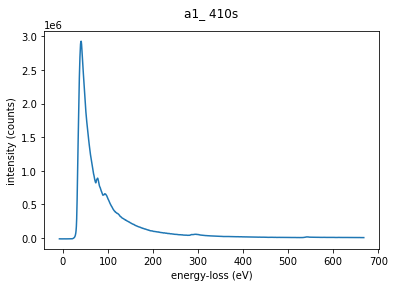

In [4]:
# We might run this code cell several times and so we first try to close the file if open.
try:
    current_dataset.h5_dataset.file.close()
except:
    pass

# Load file
current_dataset = ft.open_file()#os.path.join(current_directory,filename))
current_channel = current_dataset.h5_dataset.file['Measurement_000/Channel_000']

current_dataset.plot()

## Data Structure

The data themselves reside in a ``sidpy dataset`` which we name ``current_dataset``.

The current_dataset has additional information stored as attributes which can be accessed through their name.

In [5]:
print(current_dataset)
current_dataset

sidpy.Dataset of type SPECTRUM with:
 dask.array<a1_ 410s, shape=(2048,), dtype=float32, chunksize=(2048,), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
energy_loss:  energy-loss (eV) of size (2048,)


sidpy.Dataset of type SPECTRUM with:
 dask.array<a1_ 410s, shape=(2048,), dtype=float32, chunksize=(2048,), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
energy_loss:  energy-loss (eV) of size (2048,)

In [6]:
print(f'size of current dataset is {current_dataset.shape}')

size of current dataset is (2048,)


The current_dataset has additional information stored as attributes which can be accessed through their name.

In [30]:
print('title: ', current_dataset.title)
print('data type: ', current_dataset.data_type)
current_dataset.metadata
print(current_channel['a1_ 410s']['original_metadata'].attrs.keys())

title:  a1_ 410s
data type:  DataType.SPECTRUM
<KeysViewHDF5 ['ApplicationBounds', 'DM-chosen_image', 'DM-file_size', 'DM-file_version', 'DM-full_file_name', 'DocumentObjectList-0-AnnotationType', 'DocumentObjectList-0-BackgroundColor', 'DocumentObjectList-0-BackgroundMode', 'DocumentObjectList-0-FillMode', 'DocumentObjectList-0-ForegroundColor', 'DocumentObjectList-0-HasBackground', 'DocumentObjectList-0-ImageDisplayInfo-BackgroundOn', 'DocumentObjectList-0-ImageDisplayInfo-CalibrationSliceId-0', 'DocumentObjectList-0-ImageDisplayInfo-CaptionOn', 'DocumentObjectList-0-ImageDisplayInfo-CaptionSize', 'DocumentObjectList-0-ImageDisplayInfo-CursorOn', 'DocumentObjectList-0-ImageDisplayInfo-CursorPosition', 'DocumentObjectList-0-ImageDisplayInfo-DimensionLabels-0', 'DocumentObjectList-0-ImageDisplayInfo-FrameOn', 'DocumentObjectList-0-ImageDisplayInfo-GridOn', 'DocumentObjectList-0-ImageDisplayInfo-GroupId', 'DocumentObjectList-0-ImageDisplayInfo-GroupList-0-DoAutoSurveyHigh', 'DocumentObj

## File Structure
The current_channel (like a directory in a file system) contains several groups.

Below I show how to access one of those groups.

In [49]:
print(current_channel.keys())
def add_data(dataset, h5_group=None):
    """Write data to hdf5 file

    Parameters
    ----------
    dataset: sidpy.Dataset
        data to write to file
    h5_group: None, sidpy.Dataset, h5py.Group, h5py.Datset, h5py.File
        identifier to which group the data are added (if None the dataset must have a valid h5_dataset)

    Returns:
    log_group: h5py.Dataset
        reference the dataset has been written to. (is also stored in h5_dataset attribute of sipy.Dataset)
    """

    if h5_group is None:
        if isinstance(dataset.h5_dataset, h5py.Dataset):
            h5_group = dataset.h5_dataset.parent.parent.parent
    if isinstance(h5_group, h5py.Dataset):
        h5_group = h5_group.parent.parent.parent
    elif isinstance(h5_group, sidpy.Dataset):
        h5_group = h5_group.h5_dataset.parent.parent.parent
    elif isinstance(h5_group, h5py.File):
        h5_group = h5_group['Measurement_000']
        
    if not isinstance(h5_group, h5py.Group):
        raise TypeError('Need a valid indentifier for a hdf5 group to store data in')

    log_group = sidpy.hdf.prov_utils.create_indexed_group(h5_group, 'Channel_')
    h5_dataset = pyNSID.hdf_io.write_nsid_dataset(dset, log_group)
    
    if hasattr(dataset, 'meta_data'):
        if 'analysis' in dataset.meta_data:
            log_group['analysis'] = dataset.meta_data['analysis']
            
    dataset.h5_dataset = h5_dataset
    return h5_dataset

print(current_channel)
current_dataset.metadata= {'a': 'nix', 'b': 'gara'}
#new_data = pyNSID.hdf_io.write_results(current_channel.parent, dataset=current_dataset)
new_data = add_data(current_dataset, h5_group=None)

print(current_dataset.h5_dataset)
print(new_data)

<KeysViewHDF5 ['a1_ 410s']>
<HDF5 group "/Measurement_000/Channel_000" (1 members)>
<HDF5 group "/Measurement_000/Log_005" (1 members)>


C:\Users\gduscher\Anaconda3\lib\site-packages\sidpy\hdf\hdf_utils.py:419: UserWarning: Casting attribute value: <sidpy.viz.dataset_viz.CurveVisualizer object at 0x000001AA2BE84B50> of type: <class 'sidpy.viz.dataset_viz.CurveVisualizer'> to str
  warn('Casting attribute value: {} of type: {} to str'
C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:351: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


In [50]:
print(dict(new_data['a1_ 410s']['metadata'].attrs))

{'a': 'nix', 'b': 'gara'}


An important attribute in ``current_dataset`` is the ``original_metadata`` group, where all the original metadata of your file reside in the ``attributes``. This is usually a long list for ``dm3`` files.

In [57]:
current_dataset.h5_dataset.parent['original_metadata'].keys()

<KeysViewHDF5 []>

In [60]:
for key,value in current_dataset.h5_dataset.parent['original_metadata'].attrs.items():
    print(key, value)
print(current_dataset.h5_dataset)    

<HDF5 dataset "a1_ 410s": shape (2048,), type "<f4">
ApplicationBounds [   0    0 1437 2152]
DM-chosen_image 1
DM-file_size 321545
DM-file_version 3
DM-full_file_name C:/Users/gduscher/OneDrive - University of Tennessee/2020 Experiment/Elijah-EELS/a1_ 410s.dm3
DocumentObjectList-0-AnnotationType 20
DocumentObjectList-0-BackgroundColor [-1 -1 -1]
DocumentObjectList-0-BackgroundMode 2
DocumentObjectList-0-FillMode 2
DocumentObjectList-0-ForegroundColor [-1  0  0]
DocumentObjectList-0-HasBackground False
DocumentObjectList-0-ImageDisplayInfo-BackgroundOn True
DocumentObjectList-0-ImageDisplayInfo-CalibrationSliceId-0 0
DocumentObjectList-0-ImageDisplayInfo-CaptionOn True
DocumentObjectList-0-ImageDisplayInfo-CaptionSize 12
DocumentObjectList-0-ImageDisplayInfo-CursorOn False
DocumentObjectList-0-ImageDisplayInfo-CursorPosition 0.0
DocumentObjectList-0-ImageDisplayInfo-DimensionLabels-0 
DocumentObjectList-0-ImageDisplayInfo-FrameOn True
DocumentObjectList-0-ImageDisplayInfo-GridOn True
Do

In [ ]:
print(current_channel.keys())

## Adding Data

To add another dataset that belongs to this measurement we will use the **h5_add_channel** from  **filetools** in the  pyTEMlib package.

Here is how we add a channel there.

We can also add a new measurement group (add_measurement in pyTEMlib) for similar datasets.

This is equivalent to making a new directory in a file structure on your computer.

In [ ]:
import pyNSID

def h5_add_channel(current_channel):
    measurement_group = h5_file[current_channel.name.split('/')[1]]
    name = pyNSID.io.hdf_utils.assign_group_index(measurement_group,'Channel')
    
    additional_channel = measurement_group.create_group(name)

def h5_add_measurement(h5_file):
    new_measurement_group = pyNSID.io.hdf_utils.create_indexed_group(h5_file,'Measurement')
ft.h5_add_measurement(h5_file)    
ft.h5_tree(h5_file)  #wraps sidpy.hdf_utils.print_tree(h5_file)

We use above functions to add the content of a (random) data-file to the current file.

This is important if you for example want to add a Z-contrast or survey-image to an spectrum image.

Therefore, these functions enable you to collect the data from different files that belong together.


In [ ]:
new_channel = ft.h5_add_data(current_channel)

ft.h5_tree(h5_file)  #wraps usid.hdf_utils.print_tree(h5_file)

## Adding additional information

Similarly we can add a whole new measurement group or a structure group.

This function will be contained in the KinsCat package of pyTEMlib.

If you loaded the example image, with graphite and ZnO both are viewed in the [1,1,1] zone axis.


In [ ]:
import pyTEMlib.KinsCat as ks         # Kinematic sCattering Library
                             # with Atomic form factors from Kirklands book

def h5_add_crystal_structure(h5_file, crystal_tags):
    structure_group = pyNSID.io.hdf_utils.create_indexed_group(h5_file,'Structure')
    
    structure_group['unit_cell'] = crystal_tags['unit_cell' \
                                                '' \
                                                '' \
                                                '']
    structure_group['relative_positions'] = crystal_tags['base']
    structure_group['title'] = str(crystal_tags['crystal_name'])
    structure_group['_'+crystal_tags['crystal_name']] = str(crystal_tags['crystal_name'])
    structure_group['elements'] = np.array(crystal_tags['elements'],dtype='S')
    if 'zone_axis' in structure_group:
        structure_group['zone_axis'] = np.array(crystal_tags['zone_axis'], dtype=float)
    else:
        structure_group['zone_axis'] = np.array([1.,1.,1.], dtype=float)
        
    h5_file.flush()
    return structure_group

                                                                                 
crystal_tags = ks.structure_by_name('Graphite')
h5_add_crystal_structure(h5_file, crystal_tags)
                                                                                
crystal_tags = ks.structure_by_name('ZnO')
ft.h5_add_crystal_structure(h5_file, crystal_tags)

sidpy.hdf_utils.print_tree(h5_file)


## Keeping Track of Analysis and Results
A notebook is notorious for getting confusing, especially if one uses different notebooks for different task, but store them in the same file.

If you like a result of your calculation, log it.
|
The function will write your calculation to the pyUSID style file and attaches a time stamp.

The two functions below are part of  file_tools of pyTEMlib.

In [ ]:
info_dictionary = {'analysis': 'Nothing', 'name': 'Nothing'}

log_group = ft.log_results(current_dataset, info_dictionary)

usid.hdf_utils.print_tree(h5_file)


## An example for a log
We log the Fourier Transform of the image we loaded

First we perform the calculation

In [ ]:
## Access the data of the loaded image
data = current_dataset

## The data log goes in the dictionary out_tags
out_tags = {}
## data tag contains the newly calculated result
out_tags['data'] = np.fft.fftshift(np.fft.fft2(data))

## meta data (can be anything, but good practice is to be compatible with pyUSID data set)
out_tags['analysis']= 'Fourier_Transform'

out_tags['spatial_origin_x'] = data.shape[0]/2
out_tags['spatial_origin_y'] = data.shape[1]/2

for dim in current_dataset.dims:
    if dim.label == 'x': scale_x = dim[0][1]-dim[0][0]
    if dim.label == 'y': scale_y = dim[0][1]-dim[0][0]     
        
out_tags['spatial_scale_x'] = 1.0/scale_x/data.shape[0]
out_tags['spatial_scale_y'] = 1.0/scale_y/data.shape[1]
out_tags['spatial_size_x'] = data.shape[0]
out_tags['spatial_size_y'] = data.shape[1]
out_tags['spatial_units'] = '1/nm'


FOV_x = out_tags['spatial_origin_x']* scale_x
FOV_y = out_tags['spatial_origin_y']* scale_y
out_tags['image_extent'] = [-FOV_x,FOV_x,FOV_y, -FOV_y]
fig = plt.figure()
plt.imshow(np.log2(1+np.abs(out_tags['data'])),origin='upper', extent = out_tags['image_extent'])
plt.xlabel('reciprocal distance ['+ out_tags['spatial_units']+']');


Now that we like this we log it.

Please note that just saving the fourier transform would not be good as we also need the scale and such.

In [ ]:
import importlib
importlib.reload(ft)


out_tags['name'] = 'fft'
out_tags['units'] = '1/nm'
out_tags['data_type'] = 'image'

log_group = ft.log_results(current_dataset, out_tags)
log_dataset = log_group['nDim_Data']
ft.h5_tree(h5_file)
fig = plt.figure()
plt.title(log_group['analysis'][()])
plt.imshow(np.log2(1+np.abs(log_dataset)),origin='upper', extent = log_group['image_extent'][()])
plt.xlabel('reciprocal distance ['+ log_group['units'][()]+']');


Please close the file

In [ ]:
print(h5_file.filename)
h5_file.close()


## Open h5_file
Open the h5_file that we just created

In [ ]:
h5_file = ft.h5_open_file()

current_channel = h5_file['Measurement_000/Channel_000']
current_dataset = current_channel['nDim_Data']

ft.h5_plot(current_dataset)

In [ ]:
plt.figure()
plt.imshow(np.array(current_dataset));

### Short check if we got the data right
we print the tree and we plot the data

In [ ]:
# See if a tree has been created within the hdf5 file:
ft.h5_tree(h5_file)
image_tags = dict(h5_file['Measurement_000/Channel_000'].attrs)
for key in image_tags:
    if 'original' not in key:
        #print(key,': ',image_tags[key])
        pass
current_channel = h5_file['Measurement_000/Channel_000']



### Add more data to this set

Often more than one data set belong together.
For instance a spectrum image has a survey image and a Z-contrast image recorded with the survey image.

Here we jsut load another image for example *p1-3-hr3b.dm3*

In [ ]:
current_channel = ft.h5_add_data(current_channel)
    
measurement_group = current_channel.parent
    
for key in list(measurement_group.keys()):
    if 'title' in measurement_group[key].keys(): 
        print(key,': ',measurement_group[key]['title'][()])
    else:
        print(key,': ')   

Let's see what you selected


In [ ]:
current_dataset = current_channel['nDim_Data']

ft.h5_plot(current_dataset)

## If we are done, we close the pyUID style file.

This is necessary to make the file ready to be opened by another notebook or program.

In [ ]:
h5_file.close(

## Navigation

<font size = "4"> 
    
**Back: [Matplotlib and Numpy for Micrographs](CH1_03-Data_Representation.ipynb)**<br>
**Next: [Diffraction](CH2_00-Diffraction.ipynb)**<br>
**Up Chapter 1: [Introduction](CH1_00-Introduction.ipynb)**<br>
**List of Content: [Front](_MSE672_Intro_TEM.ipynb)**
</font>